In [28]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [29]:
# read training and test data from csv files
TRAINING_PATH = "./train.csv"
TESTING_PATH = "./test.csv"

In [30]:

spark = SparkSession.builder.appName("RandomForestExample").getOrCreate()
sc = spark.sparkContext

In [31]:
training_rdd = spark.read.csv(TRAINING_PATH, header=True, inferSchema=True)
testing_rdd = spark.read.csv(TESTING_PATH, header=True, inferSchema=True)

In [32]:
# training_rdd.show(10)
# testing_rdd.show(10)

# print dataset length
print("Training data length: ", training_rdd.count())
print("Testing data length: ", testing_rdd.count())

# print the count of label values in training data
training_rdd.groupBy("label").count().show()
testing_rdd.groupBy("label").count().show()

Training data length:  177041
Testing data length:  58329
+-----+------+
|label| count|
+-----+------+
|    1|101480|
|    0| 75561|
+-----+------+

+-----+-----+
|label|count|
+-----+-----+
|    1|33370|
|    0|24959|
+-----+-----+



In [33]:
# print column data types
training_rdd.printSchema()

root
 |-- URLLength: integer (nullable = true)
 |-- URLSimilarityIndex: double (nullable = true)
 |-- CharContinuationRate: double (nullable = true)
 |-- TLDLegitimateProb: double (nullable = true)
 |-- URLCharProb: double (nullable = true)
 |-- NoOfSubDomain: integer (nullable = true)
 |-- LetterRatioInURL: double (nullable = true)
 |-- DegitRatioInURL: double (nullable = true)
 |-- SpacialCharRatioInURL: double (nullable = true)
 |-- LineOfCode: integer (nullable = true)
 |-- LargestLineLength: integer (nullable = true)
 |-- URLTitleMatchScore: double (nullable = true)
 |-- NoOfURLRedirect: integer (nullable = true)
 |-- NoOfSelfRedirect: integer (nullable = true)
 |-- NoOfPopup: integer (nullable = true)
 |-- NoOfiFrame: integer (nullable = true)
 |-- NoOfImage: integer (nullable = true)
 |-- NoOfCSS: integer (nullable = true)
 |-- NoOfJS: integer (nullable = true)
 |-- NoOfSelfRef: integer (nullable = true)
 |-- NoOfEmptyRef: integer (nullable = true)
 |-- NoOfExternalRef: integer 

In [34]:
# #convert all columns to integers
# for column in training_rdd.columns:
#     training_rdd = training_rdd.withColumn(column, training_rdd[column].cast("int"))

# for column in testing_rdd.columns:
#     testing_rdd = testing_rdd.withColumn(column, testing_rdd[column].cast("int"))

# training_rdd.printSchema()
# testing_rdd.printSchema()

In [35]:
training_rdd.show(10)

+---------+------------------+--------------------+-----------------+-----------+-------------+----------------+---------------+---------------------+----------+-----------------+------------------+---------------+----------------+---------+----------+---------+-------+------+-----------+------------+---------------+-------+--------+----------+------+------------+--------------+---------------------+------------+---------------+---------------+----------------+----+---+------+----------------+-----+
|URLLength|URLSimilarityIndex|CharContinuationRate|TLDLegitimateProb|URLCharProb|NoOfSubDomain|LetterRatioInURL|DegitRatioInURL|SpacialCharRatioInURL|LineOfCode|LargestLineLength|URLTitleMatchScore|NoOfURLRedirect|NoOfSelfRedirect|NoOfPopup|NoOfiFrame|NoOfImage|NoOfCSS|NoOfJS|NoOfSelfRef|NoOfEmptyRef|NoOfExternalRef|IsHTTPS|HasTitle|HasFavicon|Robots|IsResponsive|HasDescription|HasExternalFormSubmit|HasSocialNet|HasSubmitButton|HasHiddenFields|HasPasswordField|Bank|Pay|Crypto|HasCopyrightIn

In [64]:
effective_cols = [
    "URLLength",
    "URLSimilarityIndex",
    "CharContinuationRate",
    "URLCharProb",
    "NoOfSubDomain",
    "DegitRatioInURL",
    "SpacialCharRatioInURL",
    "URLTitleMatchScore",
    "NoOfImage",
    "NoOfJS",
    "IsHTTPS",
    "HasTitle",
    "IsResponsive",
    "HasDescription",
    "HasExternalFormSubmit",
    "HasSocialNet",
    "HasSubmitButton",
    "HasHiddenFields",
    "HasPasswordField",
    "Bank",
    "Pay",
    "Crypto",
    "HasCopyrightInfo"
]

print("Effective columns: ", len(effective_cols))
# Specify the feature columns, excluding the label column
feature_columns = [
    col for col in training_rdd.columns if col in effective_cols]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# print("Feature columns: ", feature_columns)

# Assemble features for both train and test datasets
train_df = assembler.transform(training_rdd).select("features", "label")
test_df = assembler.transform(testing_rdd).select("features", "label")

train_df.select("features").show(10, truncate=False)

Effective columns:  23
+---------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                   |
+---------------------------------------------------------------------------------------------------------------------------+
|(23,[0,1,2,3,5,6,7],[19.0,63.08539945,1.0,0.024473088,0.368,0.105,14.28571429])                                            |
|(23,[0,1,2,3,5,6,7],[20.0,66.66666667,1.0,0.022362618,0.4,0.1,12.5])                                                       |
|(23,[0,1,2,3,4,5,6,7],[88.0,12.57170048,0.5,0.052818387,5.0,0.125,0.148,1.315789474])                                      |
|(23,[0,1,2,3,4,5,6,7],[22.0,44.48979592,0.4,0.001783516,2.0,0.5,0.182,10.0])                                               |
|(23,[0,1,2,3,4,5,6,11],[47.0,22.74695122,0.346153846,0.045556647,1.0,0.17,0.128,1.0])         

In [66]:
# Create and train the Random Forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features",
                            numTrees=100, maxDepth=4, maxBins=32, seed=42
                            )
rf_model = rf.fit(train_df)

# Make predictions on the test set
predictions = rf_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy:.4f}")

Test Accuracy = 0.9999


In [40]:
# confusion matrix

predictions.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|24959|
|    1|       1.0|33370|
+-----+----------+-----+



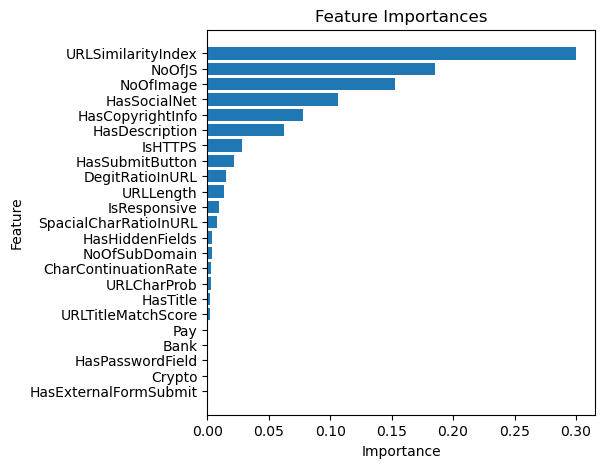

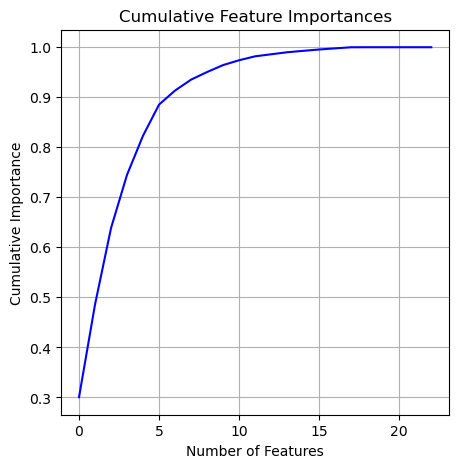

In [80]:
# show most important features in plot
import matplotlib.pyplot as plt
import numpy as np
# Retrieve the feature importances from the model as a list
importances = rf_model.featureImportances.toArray()

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_importances = np.array(importances)[indices]
sorted_feature_names = np.array(feature_columns)[indices]


# Create a horizontal bar plot showing the feature importances
plt.figure(figsize=(5,5))
plt.title("Feature Importances")
plt.barh(range(len(importances)), np.array(importances)[indices], align='center')
plt.yticks(range(len(importances)), np.array(feature_columns)[indices])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()


# show accumulated importance on 
importances = np.array(importances)
indices = np.argsort(importances)[::-1]
importances = importances[indices]
cum_importances = np.cumsum(importances)
plt.figure(figsize=(5,5))
plt.title("Cumulative Feature Importances")
plt.plot(range(len(importances)), cum_importances, 'b-')
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.grid(True)
plt.show()

In [83]:
# pick the columns that contribute to 95% of the importance


# Pick the features that contribute up to 95% of importance
threshold = 0.95
num_important_features = np.argmax(cum_importances >= threshold) + 1

# Get the selected feature names
selected_features = sorted_feature_names[:num_important_features]

print(f"Number of features contributing up to {threshold * 100}% importance: {num_important_features}")
print("Selected features:", selected_features)

Number of features contributing up to 95.0% importance: 9
Selected features: ['URLSimilarityIndex' 'NoOfJS' 'NoOfImage' 'HasSocialNet'
 'HasCopyrightInfo' 'HasDescription' 'IsHTTPS' 'HasSubmitButton'
 'DegitRatioInURL']


In [84]:
feature_columns = [
    col for col in training_rdd.columns if col in selected_features]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# print("Feature columns: ", feature_columns)

# Assemble features for both train and test datasets
train_df = assembler.transform(training_rdd).select("features", "label")
test_df = assembler.transform(testing_rdd).select("features", "label")

train_df.select("features").show(10, truncate=False)
# Create and train the Random Forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features",
                            numTrees=100, maxDepth=4, maxBins=32, seed=42
                            )
rf_model = rf.fit(train_df)

# Make predictions on the test set
predictions = rf_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy:.4f}")

+-----------------------------------------------+
|features                                       |
+-----------------------------------------------+
|(9,[0,1],[63.08539945,0.368])                  |
|(9,[0,1],[66.66666667,0.4])                    |
|(9,[0,1],[12.57170048,0.125])                  |
|(9,[0,1],[44.48979592,0.5])                    |
|(9,[0,1],[22.74695122,0.17])                   |
|(9,[0,1,2,4],[2.271881472,0.212,1.0,1.0])      |
|[2.135921472,0.203,1.0,0.0,1.0,1.0,0.0,1.0,1.0]|
|[2.237752653,0.19,1.0,0.0,1.0,1.0,0.0,1.0,1.0] |
|(9,[0,1],[34.84562067,0.233])                  |
|(9,[0,1,3],[38.23129252,0.524,1.0])            |
+-----------------------------------------------+
only showing top 10 rows

Test Accuracy = 0.9998
